_Project instructions:_
# Data Analysis Interview Challenge
This is your chance to wow us with creative and rigorous solutions! Please include your code at the end of your submission, or in a separate file. We also accept incomplete solutions.
## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

Data description:
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

_Project submission (Leo Evancie):_

### 1. Cleaning, exploratory analysis, visualizations

First, I'll import libraries, load the .json file, inspect the top 5 rows and read the DataFrame info:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

users = pd.read_json('ultimate_data_challenge.json')
users['signup_date'] = users['signup_date'].astype('datetime64[ns]')
users['last_trip_date'] = users['last_trip_date'].astype('datetime64[ns]')

users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [2]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [3]:
users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [4]:
# Identify current day

users.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [5]:
# Create target feature based on whether last_trip_date is within 30 days of current date
users['active'] = np.where(users.last_trip_date.max() - users.last_trip_date <= dt.timedelta(days=30), 1, 0)
users[['last_trip_date','active']].head(10)

,last_trip_date,active
0,2014-06-17,1
1,2014-05-05,0
2,2014-01-07,0
3,2014-06-29,1
4,2014-03-15,0
5,2014-06-06,1
6,2014-01-25,0
7,2014-01-29,0
8,2014-02-01,0
9,2014-01-05,0


In [6]:
# Calculate percentage of active users based on target column sum and length
print('Fraction of users joining in Jan 2014 who remained active after 6 months: {}%'
      .format(round(users.active.sum()/len(users)*100, 2)))

Fraction of users joining in Jan 2014 who remained active after 6 months: 37.61%


The features which appear to contain null values are: `avg_rating_of_driver`, `phone`, and `avg_rating_by_driver`. I will examine each of them in turn to determine the best way to handle the nulls, starting with the feature containing the highest proportion of nulls:

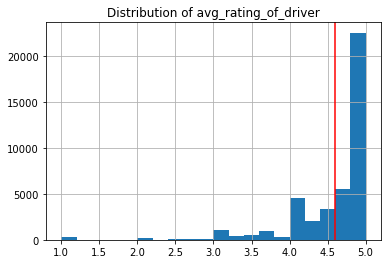

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

users.avg_rating_of_driver.hist(bins=20)
plt.title('Distribution of avg_rating_of_driver')
plt.axvline(users.avg_rating_of_driver.mean(), c='r')
plt.show()

In [8]:
print('Most common rating given to drivers: ', users.avg_rating_of_driver.mode()[0])

Most common rating given to drivers:  5.0


Over 8,000 of the 50,000 values for this feature are null. This is too many to drop entirely, so we need to choose an imputation method. Shown in red above, the mean is perhaps not the best measure of central tendency. The mode, 5.0, would better approximate the bulk of the values here. But perhaps this value correlates with another feature, by which we could create a smarter imputation? I wonder, for example, whether there is a relationship between ratings given to drivers and ratings given to users.

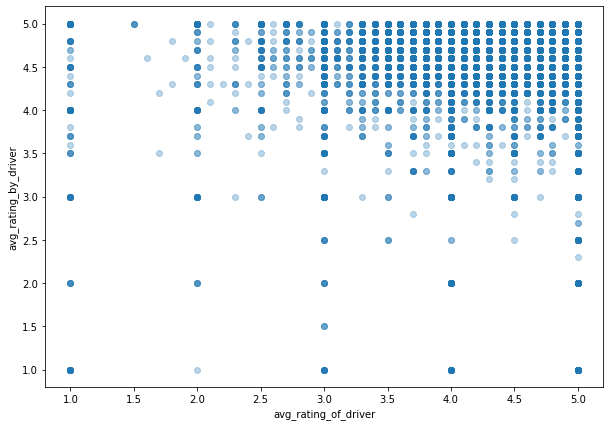

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(users.avg_rating_of_driver, users.avg_rating_by_driver, alpha=0.3)
#plt.plot(np.arange(1,6),)
plt.xlabel('avg_rating_of_driver')
plt.ylabel('avg_rating_by_driver')
plt.show()

In [10]:
from scipy.stats import pearsonr
r = pearsonr(users.avg_rating_of_driver.fillna(users.avg_rating_of_driver.mean()), users.avg_rating_by_driver.fillna(users.avg_rating_by_driver.mean()))
print(r)

(0.10166026484732596, 5.706529433286202e-115)


The correlation is slight, though statistically significant (presumably with the help of the large sample sizes). I would note, though, that by necessity, I filled null values with the mean for the above calculation. There is already some imputation at work with these figures. I don't see a great way to use the value of one to impute the other.

Perhaps more frequent users are more likely to rate their drivers? Aside from the date of their last trip, the only proxy we have for user frequency is the `trips_in_first_30_days` column. Let's see if there's anything to be gleaned there.

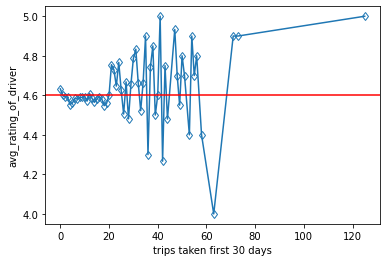

In [11]:
driver_ratings_by_trip_frequency = users.groupby(by='trips_in_first_30_days')['avg_rating_of_driver'].mean()

plt.plot(driver_ratings_by_trip_frequency, fillstyle='none', marker='d')
plt.axhline(users.avg_rating_of_driver.mean(), color='r')
plt.xlabel('trips taken first 30 days')
plt.ylabel('avg_rating_of_driver')
plt.show()

It would appear that users who took more trips during their first 30 days gave a wider range of average ratings to their drivers than those who took fewer trips during their first 30 days, however the average ratings appear to fluctuate about the mean even as the amplitude of fluctuations increases. Again, we see no compelling reason to impute nulls by anything other than the simple mean or median.

Having initially found no more sophisticated method to impute null values for `avg_rating_of_driver`, and stopping short of guessing that value through yet another round of predictive modeling, I will choose the mode as a simple imputation method. In addition to better describing the distribution we first visualized, I believe the mode (5.0) makes more sense from a user experience standpoint. When riders have singularly negative experiences, they tend to leave ratings. When users who _do_ leave ratings have mundane experiences, they tend to rate 5 out of 5. Hence, I would predict that users who choose not to rate their drivers are more likely to have had mundane (or better) experiences than to have had negative experiences, and would thus have likely chosen 5 out of 5 if they'd been forced to choose.

I will perform this imputation now, before dropping any rows on the basis of nulls in other columns, for integrity purposes.

In [12]:
users['avg_rating_of_driver'] = users['avg_rating_of_driver'].fillna(users.avg_rating_of_driver.mode()[0])
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active                  50000 non-null  int64 

With fewer than 400 nulls in the `phone` column, and about 200 nulls in the `avg_rating_by_driver` column, I think it's safe to drop those rows entirely.

In [13]:
users = users.dropna(subset=['phone','avg_rating_by_driver'])
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49406 non-null  object        
 1   trips_in_first_30_days  49406 non-null  int64         
 2   signup_date             49406 non-null  datetime64[ns]
 3   avg_rating_of_driver    49406 non-null  float64       
 4   avg_surge               49406 non-null  float64       
 5   last_trip_date          49406 non-null  datetime64[ns]
 6   phone                   49406 non-null  object        
 7   surge_pct               49406 non-null  float64       
 8   ultimate_black_user     49406 non-null  bool          
 9   weekday_pct             49406 non-null  float64       
 10  avg_dist                49406 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
 12  active                  49406 non-null  int64 

Now, we have 49,406 of our original 50,000 users, roughly 8,000 of which have an imputed `avg_rating_of_driver` score of 5.0.

Next, let's get a quick sense of how our various features relate to whether a rider is `active` 6 months after joining.

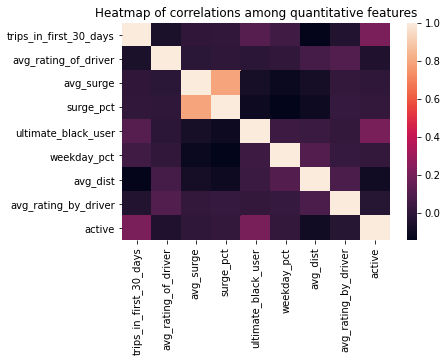

In [14]:
import seaborn as sns

sns.heatmap(users.corr())
plt.title('Heatmap of correlations among quantitative features')
plt.show()

There is virtually no correlation between `avg_dist` and `active`, weak correlations with `avg_surge`, `surge_pct`, `weekday_pct`, `avg_rating_of_driver` and `avg_rating_by_driver`, and modest correlations with `trips_in_first_30_days` and `ultimate_black_user`.

From this, I would think we can exclude `avg_dist` from our feature set, for lack of predictive value. Also, due to the very strong correlation between `avg_surge` and `surge_pct`, I believe we should only include one, so as to avoid autocorrelation within the feature set. I will keep `surge_pct`.

In [ ]:
users = users.drop(columns=['avg_dist','avg_surge'])

What about our categorical features? I am planning to use a decision-tree-based model, so we can potentially include those as well, if they look useful.

In [19]:
users.groupby(by='phone')['active'].mean().sort_values(ascending=False)

phone
iPhone     0.449864
Android    0.209826
Name: active, dtype: float64

In [20]:
users.groupby(by='city')['active'].mean().sort_values(ascending=False)

city
King's Landing    0.628403
Winterfell        0.353501
Astapor           0.256496
Name: active, dtype: float64

The type of `phone` used by the user, as well as their `city`, both have some bearing on whether or not they are active 6 months after joining. iPhone users are more than twice as likely to still be active than Android users. King's Landing-based users are nearly twice as likely to be active than Winterfell residents, and more than twice as likely to be active than Astapor residents. We should certainly include both of these features in our training data. I will create dummies and remove the original columns.

In [21]:
phone_dummies = pd.get_dummies(users.phone, prefix='phone')
city_dummies = pd.get_dummies(users.city, prefix='city')
users = pd.concat([users, phone_dummies, city_dummies], axis=1).drop(columns=['phone','city'])

And finally, we remove our date columns. For one thing, we know they all joined in January. For another, including `last_trip_date` would make our model impossibly good; the point is to be able to _predict_ activity.

In [25]:
users = users.drop(columns=['signup_date','last_trip_date'])

I'm going to use a Gradient Boosting Classifier algorithm. This is a decision-tree-based model, which is great for handling both quantitative and categorical data, and it's also robust to outliers. Another benefit of the GBC is that it's an ensemble model. The algorithm actually trains a series of decision trees, each one trained on the errors of the last, to produce a much more effective tree than we could've trained in one shot.

First, of course, we have to split our data into training and testing chunks. We will not scale or normalize columns because the algorithm we'll use does not require that practice.

In [ ]:
from sklearn.model_selection import train_test_split

y = users.active
X = users.drop('active', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_baseline = GradientBoostingClassifier()
gbc_baseline.fit(X_train, y_train)
y_train_pred = gbc_baseline.predict(X_train)
y_test_pred = gbc_baseline.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     21533
           1       0.74      0.66      0.70     13051

    accuracy                           0.79     34584
   macro avg       0.77      0.76      0.77     34584
weighted avg       0.78      0.79      0.78     34584



In [40]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      9238
           1       0.74      0.68      0.71      5584

    accuracy                           0.79     14822
   macro avg       0.78      0.77      0.77     14822
weighted avg       0.79      0.79      0.79     14822



The label '1' is applied to active users in our training set. So, the worst type of misclassification would be false positives: Truly inactive users marked active. So, we want a low false-positive rate. As such, we should pay close attention to our precision scores.

> _Precision = True Positives / (True Positives + __False Positives__)_

With FPs in the denominator, precision drops as FPs rise.

Now that we've tried out a baseline model, I will tune hyperparamers via randomized grid search. This method tries several combinations of a provided grid of possible values for the key parameters of the GBC algorithm, eventually returning the model which performs best. We'll see if the tuned model yields higher precision scores on the training and testing data.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'loss': ['deviance','exponential'],
    'learning_rate': [0.01,0.1,1],
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['friedman_mse','mse'],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,5,10],
    'max_depth': [2,3,4,5],
    'random_state': [42],
    'max_features': ['auto','sqrt','log2']
}

gbc = GradientBoostingClassifier()
gbc_random = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_grid,
    n_iter=500,
    cv=5,
    random_state=42
)

gbc_random.fit(X_train, y_train)

In [45]:
gbc_random.best_params_

{'random_state': 42,
 'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 5,
 'loss': 'deviance',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

In [43]:
y_train_pred = gbc_random.predict(X_train)
y_test_pred = gbc_random.predict(X_test)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     21533
           1       0.77      0.69      0.73     13051

    accuracy                           0.81     34584
   macro avg       0.80      0.78      0.79     34584
weighted avg       0.81      0.81      0.80     34584



In [44]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      9238
           1       0.73      0.71      0.72      5584

    accuracy                           0.79     14822
   macro avg       0.78      0.78      0.78     14822
weighted avg       0.79      0.79      0.79     14822



Interesting... With this set of features, and that parameter grid, and 500 iterations of randomized grid search with cross-validation... We basically did not improve the model at all. A good sign that further feature-engineering is called for.

### Discussion
A first pass of modeling with the Gradient Boosting Classifier produced a model that predicts active users with about 79% accuracy (overall success) and 0.73 precision (a measure that improves as false-positives decrease).

We learned that Apple phone users are much more likely to remain active than Android users, and that King's Landing residents are more likely to remain active than residents of other cities. There is also moderate predictive value in whether a user is an Ultimate Black member, as well as how many rides they took in their first month.

One way to action these insights is to lean further into these characteristics. For example: Promote the app to Apple users disproportionately more than to Android users; push digital and physical advertisements in King's Landing; offer free trials of Ultimate Black to encourage more sign-ups; introduce an incentive whereby users who complete a certain number of rides in their first month on the app receive a voucher/gift/etc.